In [140]:
from mne_bids import BIDSPath, write_raw_bids, get_anonymization_daysback
import random
import numpy as np
import itertools
import mne
import os
import sys
import re
import glob
import pandas as pd
import seaborn as sns
from bids import BIDSLayout
from util.io.iter_raw_paths import iter_raw_paths
from statsmodels.stats.anova import AnovaRM
import statsmodels.api as sm
import statsmodels.formula.api as smf

## N1 scores

In [110]:
files = glob.glob('../data/sleep/*')
dfs = []
for file in files:
    filt = re.compile('(([0-9]|[1-9][0-9]){1,2})')
    sub = re.search(filt, file).group(0)

    df = pd.read_csv(file, header = None)
    N1 = float(df[1][df[0] == 'N1'])
    
    df = pd.DataFrame({
        'sub': [sub],
        'N1': [N1],
    })
    dfs.append(df)
N1 = pd.concat(dfs)
N1['sub'] = N1['sub'].astype(int) # convert sub to an int

In [111]:
# Counts
print(sum(N1.N1 == 0))
print(sum(N1.N1 > 0))

31
17


## FFR Power

In [112]:
power = pd.read_csv('all_stims_power.csv')

In [113]:
stim_freqs = (50, 100, 150, 200, 250)
all_stims_power = []
for stim_freq in stim_freqs:
    idx = np.abs(power.frequency - stim_freq).argmin()
    hz = power.frequency[idx]
    stim_power = power[power.frequency == hz]
    stim_power = stim_power[stim_power.stimulus == stim_freq]
    stim_power = stim_power.reset_index(drop = True)
    
    all_stims_power.append(stim_power)
all_stims_power = pd.concat(all_stims_power, ignore_index = False)

In [114]:
all_stims_power = all_stims_power.sort_values(['subject', 'stimulus'])
all_stims_power

,subject,stimulus,index,frequency,power
20,3,50,10.0,49.792531,10.078037
20,3,100,20.0,99.585062,0.106273
20,3,150,30.0,149.377593,15.763307
20,3,200,40.0,199.170124,15.484513
20,3,250,50.0,248.962656,17.465075
...,...,...,...,...,...
34,44,50,10.0,49.792531,14.048093
34,44,100,20.0,99.585062,12.020207
34,44,150,30.0,149.377593,14.033119
34,44,200,40.0,199.170124,16.817670


#### Add N1 scores to dataframe

In [115]:
# Remove subs not in both data frames
sleep_subs = np.unique(N1['sub'])
all_stims_power = all_stims_power[all_stims_power.subject.isin(sleep_subs)] 
spec_subs = np.unique(all_stims_power.subject)
N1 = N1[N1['sub'].isin(spec_subs)]

In [116]:
# Sum N1 scores for subs with two files
duplicated_subs = N1['sub'][N1['sub'].duplicated()]
for sub in duplicated_subs:
    temp = N1[N1['sub'] == sub]
    summed_N1 = sum(temp.N1)
    N1 = N1[N1['sub'] != sub]
    d = {'sub': sub, 'N1': summed_N1}
    N1 = N1.append(d, ignore_index = True)
N1['sub'] = N1['sub'].astype(int) # convert sub to an int

    sub         N1
0     8   0.000000
1     9   0.000000
2    15  11.500000
3    10   0.000000
4    14   0.000000
5    16   1.500000
6    26   2.500000
7    29   0.000000
8    36   0.000000
9    13   0.000000
10   39   0.000000
11   17   0.000000
12   37   0.000000
13   31   0.500000
14   23   1.000000
15   43   9.000000
16   28   9.000000
17   40   0.000000
18   20   3.500000
19   42   0.000000
20   30   0.000000
21   22   0.000000
22   11   3.000000
23   34   0.000000
24    6   0.000000
25   33   0.000000
26   18   0.000000
27   12  10.500000
28   35   0.000000
29    7   0.000000
30   19   0.000000
31   27   0.000000
32   44   0.000000
33   32   0.000000
34   21   0.000000
35    5   0.000000
36   25   7.500000
37   24   4.000000
38   38   0.000000
39    3   7.483333


/tmp/ipykernel_23909/2743109887.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  N1 = N1.append(d, ignore_index = True)
/tmp/ipykernel_23909/2743109887.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  N1 = N1.append(d, ignore_index = True)
/tmp/ipykernel_23909/2743109887.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  N1 = N1.append(d, ignore_index = True)


In [128]:
# Add to dataframe
all_stims_power['N1'] = list(N1.N1)*5
all_stims_power['sleep'] = list(N1.N1>0) * 5

## Plot

<AxesSubplot:xlabel='stimulus', ylabel='power'>

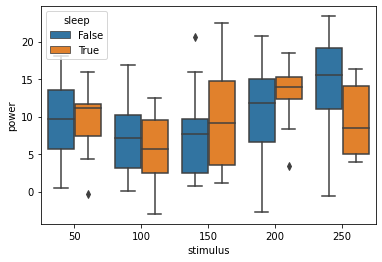

In [130]:
sns.boxplot(data = all_stims_power, x = 'stimulus', y = 'power', hue = 'sleep')

## Test

In [145]:
# Mixed effects model
md = smf.mixedlm("power ~ C(stimulus)", groups=all_stims_power["sleep"], data = all_stims_power)
mdf = md.fit()
print(mdf.summary())

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


            Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   power    
No. Observations:   200       Method:               REML     
No. Groups:         2         Scale:                30.5948  
Min. group size:    65        Log-Likelihood:       -619.4462
Max. group size:    135       Converged:            Yes      
Mean group size:    100.0                                    
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           9.493    0.872 10.891 0.000  7.785 11.202
C(stimulus)[T.100] -3.002    1.236 -2.428 0.015 -5.425 -0.578
C(stimulus)[T.150] -0.775    1.235 -0.628 0.530 -3.195  1.645
C(stimulus)[T.200]  1.726    1.237  1.395 0.163 -0.698  4.150
C(stimulus)[T.250]  3.708    1.237  2.998 0.003  1.283  6.132
Group Var           0.000                                    



/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [146]:
# Mixed effects model, sleep as categorical
md = smf.mixedlm("power ~ C(stimulus) + C(sleep)", groups=all_stims_power["subject"], data = all_stims_power)
mdf = md.fit()
print(mdf.summary())

            Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   power    
No. Observations:   200       Method:               REML     
No. Groups:         40        Scale:                14.2574  
Min. group size:    5         Log-Likelihood:       -581.3192
Max. group size:    5         Converged:            Yes      
Mean group size:    5.0                                      
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           9.447    0.890 10.608 0.000  7.701 11.192
C(stimulus)[T.100] -3.025    0.848 -3.567 0.000 -4.687 -1.363
C(stimulus)[T.150] -0.822    0.859 -0.957 0.339 -2.506  0.862
C(stimulus)[T.200]  1.726    0.844  2.044 0.041  0.071  3.381
C(stimulus)[T.250]  3.708    0.844  4.391 0.000  2.053  5.362
C(sleep)[T.True]    0.187    0.637  0.293 0.770 -1.062  1.435
Group Var          1

In [148]:
# Mixed effects model, N1 as continuous
md = smf.mixedlm("power ~ C(stimulus) + N1", groups=all_stims_power["subject"], data = all_stims_power)
mdf = md.fit()
print(mdf.summary())

            Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   power    
No. Observations:   200       Method:               REML     
No. Groups:         40        Scale:                14.2558  
Min. group size:    5         Log-Likelihood:       -583.1765
Max. group size:    5         Converged:            Yes      
Mean group size:    5.0                                      
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           9.443    0.885 10.674 0.000  7.709 11.177
C(stimulus)[T.100] -3.042    0.850 -3.577 0.000 -4.709 -1.375
C(stimulus)[T.150] -0.863    0.873 -0.989 0.323 -2.574  0.848
C(stimulus)[T.200]  1.757    0.848  2.072 0.038  0.095  3.419
C(stimulus)[T.250]  3.717    0.845  4.401 0.000  2.062  5.373
N1                  0.038    0.096  0.396 0.692 -0.150  0.226
Group Var          1